## Section 4: `rasterio`

**Some of the codes here may differ slightly from Lab 5. They should all be functional but we keep updating them to be simpler and more accessible.**

"Reading and writing data files is a spatial data programmer's bread and butter." This section explains how to use `rasterio` to read existing GeoTIFF files and performing some useful operations on them. Let's start by importing a bunch of packages.

In [1]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
import rasterio.transform
import rasterio.mask
import rasterio.warp
import rasterio.windows

from matplotlib.colors import LinearSegmentedColormap

In [2]:
%matplotlib inline

### What is a GeoTIFF file?

Think of a GeoTIFF file as a collection of actual rasters (we will later deal with them as `numpy.ndarray`) and a collection of metadata that contains georeferencing information. The potential metadata information includes map projection, coordinate systems, and everything else necessary to establish the exact spatial reference for the file. Let's load a GeoTIFF.

*Introduction of the dataset, taken from Lab 5: This file contains a field describing the estimated distribution of all people on Earth in the year 2000. The data comes from the [Gridded Population of the World data set](https://sedac.ciesin.columbia.edu/data/set/gpw-v4-population-count-rev11) produced by a team at Columbia University. We'll be using the version provided at a 15 arcminute resolution (about 30km). Constructing this data set was a major project and this data set is widely used by researchers around the world. This version of the data set describes the total number of individuals that are estimated to have lived in each grid cell in the year 2000.*

### Metadata in `rasterio`

In [3]:
dataset = rasterio.open('Lab5_GPW.tif')

We want to know how many layers (bands) there are in the file. A band is like a layer, or a channel. An RGB image, for example, has three channels/bands/layers. Each band shares the same georeferencing information with each other.

In [4]:
dataset.count

1

Or alternatively,

In [5]:
dataset.indexes

(1,)

If you see `(1,)` that means that there is only one band in the raster. `rasterio` starts counting from 1.

We can view the geographic coordinate system by

In [6]:
dataset.crs

CRS.from_epsg(4326)

The output is EPSG 4326/WGS84: World Geodetic System 1984, commonly used in GPS. This maps a point on earth to a set of longitude, latitude coordinate (notice that epsg 4326 uses the order [lon, lat]). Next, we can check how many grid cells there are by

In [7]:
dataset.shape

(720, 1440)

In [8]:
# notice the sequence of height and width here!
# this is rasterio convention, which can be different from other packages
# e.g. some image processing packages
dataset.height, dataset.width

(720, 1440)

See the bounds of the GeoTIFF 

In [9]:
dataset.bounds

BoundingBox(left=-180.0, bottom=-90.0, right=179.99999999999983, top=89.99999999999991)

In [10]:
# you can of course also view all the metadata
dataset.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4028230607370965e+38,
 'width': 1440,
 'height': 720,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.2499999999999999, 0.0, -180.0,
        0.0, -0.2499999999999999, 89.99999999999991)}

`'nodata'` refers to a special value that rasterio uses to store NaN values. `'transform'` refers to six values that rasterio uses to record the scale and the position of the raster. This can be used to convert x, y coordinate (coord in the specified crs, e.g., in lon, lat) to i, j coordinate (row and col number on a raster, coord in image space).

In [11]:
# this converts x, y to row, col
dataset.index(0, 0)

(359, 720)

In [12]:
# this converts row, col to x, y
dataset.xy(0, 0)

(-179.875, 89.87499999999991)

When you `rasterio.open()` something, you are not actually reading the whole raster file. You are only reading the metadata. This is a really nice property because sometimes a geotiff file could be too large to fit into your memory, and rasterio lets you read only parts of that image.

### Rasters as numpy arrays
Enough with the metadata, now we want to actually read the real data.

In [13]:
# read the first dimension of the array (there's only one)
band = dataset.read(1)

This is now a numpy array that you can operate on. You can do any kind of map algebra as long as it doesn't change the georeferencing.

### 20-min Exercise: Plot the data with a heat map

In [14]:
# TODO: WRITE YOUR CODES HERE
# define color palette
nodes = [0, 0.5, 1]  # positions for each color from 0-1
color_scheme = ['white', 'yellow', 'red']  # corresponds to nodes
custom_cmap = LinearSegmentedColormap.from_list(
    'WhiteYellowRed', list(zip(nodes, color_scheme)))
custom_cmap.set_under('gray')  # set values under vmin to gray
custom_cmap.set_over('red')  # set values over vmax to black

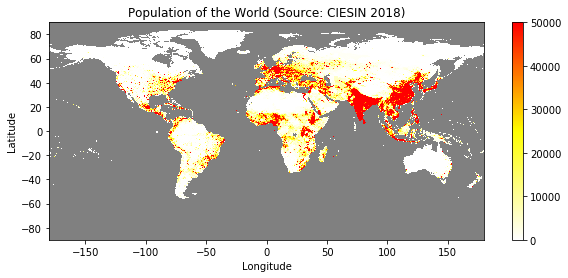

In [15]:
# plotting starts
fig, ax = plt.subplots(figsize=(10, 4))
im = ax.imshow(band,
               cmap=custom_cmap,
               extent=(-180, 180, -90, 90),
               vmin=0, vmax=50000)
fig.colorbar(im)
# label axes and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Population of the World (Source: CIESIN 2018)')
plt.show()

### 20-min Exercise: Overlay a heat map with a shapefile

The shapefile is `MEX_adm0.shp`. Zoom into Mexico in the figure.

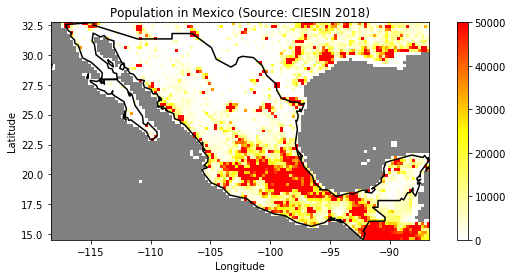

In [16]:
# TODO: WRITE YOUR CODES HERE
# load shapefile
shp = gpd.read_file('MEX_adm0.shp')
# this reduces the number of vertices and accelerates processing
shp = shp.geometry[0].simplify(0.1, preserve_topology=False)
# plotting starts
fig, ax = plt.subplots(figsize=(10, 4))
# heat map
im = ax.imshow(band,
               cmap=custom_cmap,
               vmin=0, vmax=50000,
               extent=(-180, 180, -90, 90))
fig.colorbar(im)
# plot country boundary
for poly in shp:
    ax.plot(*poly.exterior.xy, 'k-')
# zoom in
ax.set_xlim((shp.bounds[0], shp.bounds[2]))
ax.set_ylim((shp.bounds[1], shp.bounds[3]))
# label axes and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Population in Mexico (Source: CIESIN 2018)')
plt.show()

### 20-min Exercise: With the `rasterio.mask.mask()` function, clip the raster with the shapefile.

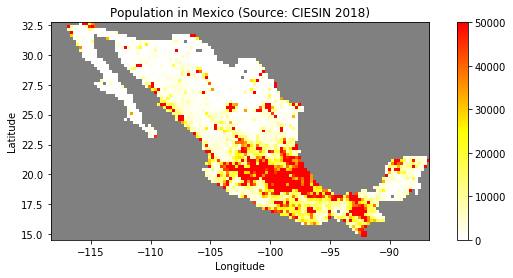

In [18]:
# TODO: WRITE YOUR CODES HERE
clipped_array, _ = rasterio.mask.mask(dataset, shp, nodata=-1)
clipped_array = clipped_array.squeeze(0)
# plotting starts
fig, ax = plt.subplots(figsize=(10, 4))
im = ax.imshow(clipped_array, cmap=custom_cmap,
               extent=(-180, 180, -90, 90),
               vmin=0, vmax=50000)
fig.colorbar(im)
# zoom in
ax.set_xlim((shp.bounds[0], shp.bounds[2]))
ax.set_ylim((shp.bounds[1], shp.bounds[3]))
# label axes and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Population in Mexico (Source: CIESIN 2018)')
plt.show()

In [19]:
type(shp)

shapely.geometry.multipolygon.MultiPolygon

### Reprojection in `rasterio`

Suppose that we want to reproject this raster onto the Pseudo Mercator system - this is super useful as many web apps use this system (e.g., Google Maps). The ID for this coordinate reference system is 3857.

In [40]:
# declares the destination coord system
dst_crs = {'init': 'EPSG:3857'}

The Pseudo Mercator system only covers 85.06 S to 85.06 N. So we would want to 'subset' our raster `dataset`. Unlike in pandas, etc., this isn't going to be very straightforward.

In [41]:
# since web mercator only covers latitude of -85.06 to 85.06
# calculate the height of the subsetted array first
height = int(dataset.height * 85 / 90)
# subset the source array (read values within 85S to 85N only)
src_array = dataset.read(1, window=rasterio.windows.Window(
    col_off=0, row_off=int((dataset.height - height) / 2),
    width=dataset.width, height=height))
# calculate a new `transform` for the original raster
# this is an object that keeps track of geocoding information
# for the original raster
src_transform = rasterio.transform.Affine(
    dataset.transform.a, dataset.transform.b,
    dataset.transform.c, dataset.transform.d,
    dataset.transform.e, 85)

Until now we have been 'subsetting' our original raster and extract the part that's in 85S-85N. Apart from subsetting our numpy array, we would also want to update some geo metadata information, which is what we did with `src_transform`. Now let's compute the metadata of the new destination raster.

In [42]:
# this calculates the transform to be applied onto
# the original raster
dst_transform, dst_width, dst_height = rasterio.warp.calculate_default_transform(
    # the coordinate reference system for source raster
    src_crs=dataset.crs,
    # the coordinate reference system for destination raster
    dst_crs=dst_crs,
    # width and height for source raster
    width=dataset.width,
    height=height,
    # bounds for source raster
    left=-180,
    right=180,
    top=85,
    bottom=-85,
    # output raster size
    dst_height=256,
    dst_width=256
)

Now we want to reproject the original raster and create a new raster to store the reprojected output - let's call that `dst_array`.

In [43]:
# creates a zero array to store the reprojected raster
dst_array = np.zeros((dst_height, dst_width))
# reproject the raster array
rasterio.warp.reproject(
    source=src_array,
    destination=dst_array,
    src_transform=src_transform,
    src_crs=dataset.crs,
    dst_transform=dst_transform,
    dst_crs=dst_crs,
    resampling=rasterio.warp.Resampling.nearest)

You'll notice that the reprojected map is a square. This is a very interesting and useful property of the Pseudo Mercator system and is part of the reason why it is popular, especially in web based mapping programs.

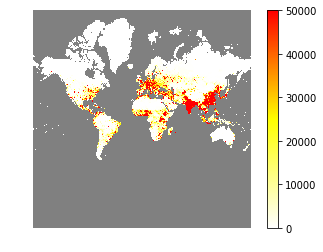

In [44]:
plt.imshow(dst_array, cmap=custom_cmap,
           vmin=0, vmax=50000)
plt.axis('off')
plt.colorbar()
plt.show()